Write a deep recommender system system/colab which does both item to item, and user to item recommendation  models

##User to Item Recommendation

imports 

In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 462 kB 28.4 MB/s 


In [ ]:
!pip install -q --upgrade tensorflow-datasets


In [ ]:
!pip install -q scann

In [ ]:
import tensorflow_recommenders as tfrs

load dataset 

In [ ]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteGUA653/movielens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incomplete1BQQ10/movielens-train.tfrecord


  0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


map dataset

In [ ]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

get unique movie list

In [ ]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

build model .  

user tower model. The retrieval model is a simple two-tower model, which is a very common model & often serves as a starter for more sophisticated recommenders.   

1. query tower - user model
2. candidate tower - movie model

In [ ]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [ ]:
movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [ ]:
#metrics
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

# loss function
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

combine all together to a model

In [ ]:
class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["user_id"])
      positive_movie_embeddings = self.movie_model(features["movie_title"])
      loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["user_id"])
    positive_movie_embeddings = self.movie_model(features["movie_title"])
    loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

build and evaluate model

In [ ]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model.fit(cached_train, epochs=5)

Epoch 1/5
10/10 [==============================] - 34s 3s/step - factorized_top_k/top_1_categorical_accuracy: 5.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0891 - factorized_top_k/top_100_categorical_accuracy: 0.1667 - loss: 69885.1129 - regularization_loss: 0.0000e+00 - total_loss: 69885.1129
Epoch 2/5
10/10 [==============================] - 28s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0161 - factorized_top_k/top_10_categorical_accuracy: 0.0340 - factorized_top_k/top_50_categorical_accuracy: 0.1621 - factorized_top_k/top_100_categorical_accuracy: 0.2867 - loss: 67523.3672 - regularization_loss: 0.0000e+00 - total_loss: 67523.3672
Epoch 3/5
10/10 [==============================] - 24s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0029 - factorized_top_k/top_5_categorical_accuracy: 0.

In [ ]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 8s 945ms/step - factorized_top_k/top_1_categorical_accuracy: 8.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0064 - factorized_top_k/top_10_categorical_accuracy: 0.0166 - factorized_top_k/top_50_categorical_accuracy: 0.1061 - factorized_top_k/top_100_categorical_accuracy: 0.2131 - loss: 31193.6292 - regularization_loss: 0.0000e+00 - total_loss: 31193.6292


{'factorized_top_k/top_100_categorical_accuracy': 0.2131499946117401,
 'factorized_top_k/top_10_categorical_accuracy': 0.016599999740719795,
 'factorized_top_k/top_1_categorical_accuracy': 0.0008500000112690032,
 'factorized_top_k/top_50_categorical_accuracy': 0.10610000044107437,
 'factorized_top_k/top_5_categorical_accuracy': 0.006399999838322401,
 'loss': 28320.34765625,
 'regularization_loss': 0,
 'total_loss': 28320.34765625}

model takes raw query features.   
recommends movies out of the entrire movies dataset

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Bridges of Madison County, The (1995)' b'Rudy (1993)'
 b'Father of the Bride Part II (1995)']


the two tower model has two components 
1. serving query model, takes features of the query and transform to query embedding
2. servering cantidate model, takes form of an appropriate nearest neighbors (ANN) index fro fast lookup of candidate

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmpnw08wie9/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpnw08wie9/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)' b'Rudy (1993)'
 b'Father of the Bride Part II (1995)']


scalable deep retrieval using scann

In [ ]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [ ]:
_, titles = scann_index(tf.constant(["42"]))

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(
      index,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmphob_x4i7/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphob_x4i7/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)' b'Rudy (1993)'
 b'Father of the Bride Part II (1995)']


##Item to Item Recommendation Model

In [ ]:
import pandas as pd
import numpy as np

In [128]:
df = pd.DataFrame({'user_0':[2,0,0,3,0,4,3,3,0,0], 'user_1':[1,0,2,0,4,0,4,3,0,0], 'user_2':[3,1,0,3,5,0,0,4,0,0], 'user_3':[5,0,0,0,5,3,0,3,0,4], 
                   'user_4':[2,0,0,0,0,4,4,3,5,0], 'user_5':[1,0,2,4,0,0,4,0,5,0], 'user_6':[0,3,0,5,0,0,4,5,0,2], 'user_7':[0,0,0,3,0,2,4,3,4,0], 
                   'user_8':[4,3,4,2,0,0,0,2,0,0], 'user_9':[0,0,3,2,5,0,4,0,3,0]}, index=['movie_0','movie_1','movie_2','movie_3','movie_4','movie_5','movie_6','movie_7','movie_8','movie_9'])
df

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9
movie_0,2,1,3,5,2,1,0,0,4,0
movie_1,0,0,1,0,0,0,3,0,3,0
movie_2,0,2,0,0,0,2,0,0,4,3
movie_3,3,0,3,0,0,4,5,3,2,2
movie_4,0,4,5,5,0,0,0,0,0,5
movie_5,4,0,0,3,4,0,0,2,0,0
movie_6,3,4,0,0,4,4,4,4,0,4
movie_7,3,3,4,3,3,0,5,3,2,0
movie_8,0,0,0,0,5,5,0,4,0,3
movie_9,0,0,0,4,0,0,2,0,0,0


In [129]:
df.values

array([[2, 1, 3, 5, 2, 1, 0, 0, 4, 0],
       [0, 0, 1, 0, 0, 0, 3, 0, 3, 0],
       [0, 2, 0, 0, 0, 2, 0, 0, 4, 3],
       [3, 0, 3, 0, 0, 4, 5, 3, 2, 2],
       [0, 4, 5, 5, 0, 0, 0, 0, 0, 5],
       [4, 0, 0, 3, 4, 0, 0, 2, 0, 0],
       [3, 4, 0, 0, 4, 4, 4, 4, 0, 4],
       [3, 3, 4, 3, 3, 0, 5, 3, 2, 0],
       [0, 0, 0, 0, 5, 5, 0, 4, 0, 3],
       [0, 0, 0, 4, 0, 0, 2, 0, 0, 0]])

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

In [ ]:
for title in df.index:

  index_user_likes = df.index.tolist().index(title) # get an index for a movie
  sim_movies = indices[index_user_likes].tolist() # make list for similar movies
  movie_distances = distances[index_user_likes].tolist() # the list for distances of similar movies
  id_movie = sim_movies.index(index_user_likes) # get the position of the movie itself in indices and distances

  print('Similar Movies to '+str(df.index[index_user_likes])+':\n')


  sim_movies.remove(index_user_likes) # remove the movie itself in indices
  movie_distances.pop(id_movie) # remove the movie itself in distances

  j = 1
  
  for i in sim_movies:
    print(str(j)+': '+str(df.index[i])+', the distance with '+str(title)+': '+str(movie_distances[j-1]))
    j = j + 1
      
  print('\n')

Similar Movies to movie_0:

1: movie_7, the distance with movie_0: 0.3195861825602283
2: movie_5, the distance with movie_0: 0.40340472183738674


Similar Movies to movie_1:

1: movie_3, the distance with movie_1: 0.3684210526315791
2: movie_7, the distance with movie_1: 0.39543645824165696


Similar Movies to movie_2:

1: movie_1, the distance with movie_2: 0.5207661617014769
2: movie_6, the distance with movie_2: 0.5243292879915494


Similar Movies to movie_3:

1: movie_6, the distance with movie_3: 0.27236779788557686
2: movie_7, the distance with movie_3: 0.2866150207251553


Similar Movies to movie_4:

1: movie_0, the distance with movie_4: 0.40453484184315647
2: movie_7, the distance with movie_4: 0.4806550570967598


Similar Movies to movie_5:

1: movie_7, the distance with movie_5: 0.38717412297165876
2: movie_0, the distance with movie_5: 0.40340472183738674


Similar Movies to movie_6:

1: movie_8, the distance with movie_6: 0.23372680904614496
2: movie_3, the distance with m

recommend similar movies to a selected movie

In [ ]:
def recommend_movie(title):

  index_user_likes = df.index.tolist().index(title) # get an index for a movie
  sim_movies = indices[index_user_likes].tolist() # make list for similar movies
  movie_distances = distances[index_user_likes].tolist() # the list for distances of similar movies
  id_movie = sim_movies.index(index_user_likes) # get the position of the movie itself in indices and distances

  print('Similar Movies to '+str(df.index[index_user_likes])+': \n')

  sim_movies.remove(index_user_likes) # remove the movie itself in indices
  movie_distances.pop(id_movie) # remove the movie itself in distances

  j = 1
    
  for i in sim_movies:
    print(str(j)+': '+str(df.index[i])+', the distance with '+str(title)+': '+str(movie_distances[j-1]))
    j = j + 1

In [ ]:
recommend_movie('movie_2')

Similar Movies to movie_2: 

1: movie_1, the distance with movie_2: 0.5207661617014769
2: movie_6, the distance with movie_2: 0.5243292879915494


recommend similar movies to a selected user

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

In [ ]:
index_for_movie = df.index.tolist().index('movie_0') # it returns 0
sim_movies = indices[index_for_movie].tolist() # make list for similar movies
movie_distances = distances[index_for_movie].tolist() # the list for distances of similar movies
id_movie = sim_movies.index(index_for_movie) # get the position of the movie itself in indices and distances
sim_movies.remove(index_for_movie) # remove the movie itself in indices
movie_distances.pop(id_movie) # remove the movie itself in distances

print('The Nearest Movies to movie_0:', sim_movies)
print('The Distance from movie_0:', movie_distances)

The Nearest Movies to movie_0: [7, 5]
The Distance from movie_0: [0.3195861825602283, 0.40340472183738674]


In [ ]:
movie_similarity = [-x+1 for x in movie_distances] # inverse distance 

predicted_rating = (movie_similarity[0]*df.iloc[sim_movies[0],7] + movie_similarity[1]*df.iloc[sim_movies[1],7])/sum(movie_similarity)
print(predicted_rating)

2.5328183015946415


In [ ]:
number_neighbors = 3
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

# copy df
df1 = df.copy()

# convert user_name to user_index
user_index = df.columns.tolist().index('user_4')

# t: movie_title, m: the row number of t in df
for m,t in list(enumerate(df.index)):
  
  # find movies without ratings by user_4
  if df.iloc[m, user_index] == 0:
    sim_movies = indices[m].tolist()
    movie_distances = distances[m].tolist()
    
    # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
    # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
    if m in sim_movies:
      id_movie = sim_movies.index(m)
      sim_movies.remove(m)
      movie_distances.pop(id_movie) 

    # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
    # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
    # Then,even the movie itself cannot be included in the indices. 
    # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
    # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
    else:
      sim_movies = sim_movies[:number_neighbors-1]
      movie_distances = movie_distances[:number_neighbors-1]
        
    # movie_similarty = 1 - movie_distance    
    movie_similarity = [1-x for x in movie_distances]
    movie_similarity_copy = movie_similarity.copy()
    nominator = 0

    # for each similar movie
    for s in range(0, len(movie_similarity)):
      
      # check if the rating of a similar movie is zero
      if df.iloc[sim_movies[s], user_index] == 0:

        # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
        if len(movie_similarity_copy) == (number_neighbors - 1):
          movie_similarity_copy.pop(s)
          
        else:
          movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

      # if the rating is not zero, use the rating and similarity in the calculation
      else:
        nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

    # check if the number of the ratings with non-zero is positive
    if len(movie_similarity_copy) > 0:
      
      # check if the sum of the ratings of the similar movies is positive.
      if sum(movie_similarity_copy) > 0:
        predicted_r = nominator/sum(movie_similarity_copy)

      # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
      # in this case, the predicted rating becomes zero as well  
      else:
        predicted_r = 0

    # if all the ratings of the similar movies are zero, then predicted rating should be zero
    else:
      predicted_r = 0

  # place the predicted rating into the copy of the original dataset
    df1.iloc[m,user_index] = predicted_r

In [ ]:
def recommend_movies(user, num_recommended_movies):

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [ ]:
recommend_movies('user_4',5)


The list of the Movies user_4 Has Watched 

movie_0
movie_5
movie_6
movie_7
movie_8


The list of the Recommended Movies 

1: movie_3 - predicted rating:3.504943460433221
2: movie_2 - predicted rating:3.0283245929027296
3: movie_1 - predicted rating:3.0
4: movie_9 - predicted rating:2.473170201830165
5: movie_4 - predicted rating:2.4658595597666277


In [ ]:
df1 = df.copy()

def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)

In [ ]:
movie_recommender('user_4', 4, 5)

The list of the Movies user_4 Has Watched 

movie_0
movie_5
movie_6
movie_7
movie_8


The list of the Recommended Movies 

1: movie_3 - predicted rating:3.504943460433221
2: movie_2 - predicted rating:3.0283245929027296
3: movie_1 - predicted rating:3.0
4: movie_9 - predicted rating:2.473170201830165
5: movie_4 - predicted rating:2.4658595597666277


Applying to real Movie Data from Movielens

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [73]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [77]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [78]:
downloaded = drive.CreateFile({'id': '1SFMHgRSc7QO5z8DUxNlooAvWsudFgLLW'}) 
downloaded.GetContentFile('movies.csv')  
movies = pd.read_csv('movies.csv', usecols=['movieId','title'])
movies.head()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [74]:
!unzip /content/drive/MyDrive/movciesdataset/ratings.csv.zip -d /content/drive/MyDrive/movciesdataset/

Archive:  /content/drive/MyDrive/movciesdataset/ratings.csv.zip
  inflating: /content/drive/MyDrive/movciesdataset/ratings.csv  


In [93]:
downloaded = drive.CreateFile({'id': '1854zw15ADLRH8oGeD7JDVDG1K3YLHIhn'})
downloaded.GetContentFile('ratings.csv')
ratings = pd.read_csv('ratings.csv')


In [94]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [97]:
ratings.head()

,movieId,userId,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [98]:
ratings2 = pd.merge(ratings, movies, how='inner', on='movieId')

In [99]:
df = ratings2.pivot_table(index='title',columns='userId',values='rating').fillna(0)
df1 = df.copy()

In [100]:
def recommend_movies(user, num_recommended_movies):

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1

In [101]:
def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)


In [102]:
movie_recommender(15, 10, 10)

The list of the Movies 15 Has Watched 

Ginger Snaps (2000)


The list of the Recommended Movies 

1: 13 Going on 30 (2004) - predicted rating:4.0
2: The Thief (1997) - predicted rating:4.0
3: 'Til There Was You (1997) - predicted rating:0.0
4: 'burbs, The (1989) - predicted rating:0.0
5: 'night Mother (1986) - predicted rating:0.0
6: *batteries not included (1987) - predicted rating:0.0
7: ...All the Marbles (1981) - predicted rating:0.0
8: ...And Justice for All (1979) - predicted rating:0.0
9: 1-900 (06) (1994) - predicted rating:0.0
10: 10 (1979) - predicted rating:0.0


DCN Layer feature crossing

In [103]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

Toy dataset

In [104]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

In [105]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

model building

In [106]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    x = self._model(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

In [107]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

model training

In [108]:

train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

In [109]:
epochs = 100
learning_rate = 0.4

In [110]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [111]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

model evaluation

In [112]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0007 using 16 parameters.
DeepNet(large) RMSE is 0.0473 using 166401 parameters.


model understanding

<Figure size 648x648 with 0 Axes>

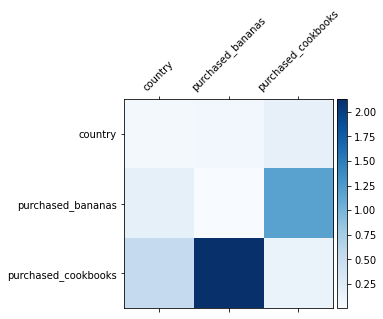

In [113]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

movielens 1M example

In [114]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0.incomplete7MAV7U/movie_lens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movie_lens downloaded and prepared to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [115]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [116]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

Model Construction

In [117]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

Model training

In [118]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [119]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [120]:
epochs = 8
learning_rate = 0.01

DCN

In [121]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 30ms/step - RMSE: 0.9339 - loss: 0.8729 - regularization_loss: 0.0000e+00 - total_loss: 0.8729


Low-rank DCN

In [122]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 24ms/step - RMSE: 0.9300 - loss: 0.8657 - regularization_loss: 0.0000e+00 - total_loss: 0.8657


DNN

In [123]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 24ms/step - RMSE: 0.9377 - loss: 0.8798 - regularization_loss: 0.0000e+00 - total_loss: 0.8798


evaluate model on test data, calculate mean and standard deviation

In [124]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9332, stdv: 0.0014
DCN (low-rank) RMSE mean: 0.9312, stdv: 0.0012
DNN            RMSE mean: 0.9390, stdv: 0.0040


model understanding

<Figure size 648x648 with 0 Axes>

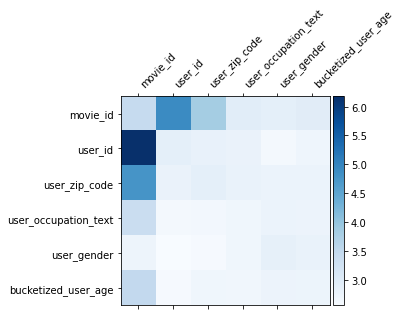

In [125]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)